# Regression and Classification Models to Predict Sale Price

---

This project was completed with a "full stack" real estate company in mind. This imaginary company would want to own the entire process of buying and selling homes - from buying the land to selling the home and everything in between, and utilise data science to make better investments. 

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [106]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso, ElasticNetCV, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# 1. Estimating the value of homes from fixed characteristics.

---

1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

This way, the company can use this information to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

The best model was found by taking the log of price values (y value) and using an Elastic Net CV model. When using pre-2010 sales data to predict 2010 sales prices based only on fixed characteristic of the house, the model was 89.6% accurate. The most important features for predicting a house's sale price were Ground Floor Size, Number of Cars that fit in the Garage, the Year a Remodel or Addition was added, Number of fireplaces & Neighborhood. If the company had all of the information on fixed characteristics of the house, it could predict with reasonable accuracy, the sale price of the home.


## Data Cleaning & EDA

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
house.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [4]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
house.shape

(1460, 81)

In [6]:
#see what types of zoning is in the data
house.MSZoning.unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [7]:
#keep only the data that is in Residential zones. 
#the only zone that is not residential is 'C (all)' which is probably commercial properties

house = house[house['MSZoning'] != 'C (all)']
house.shape

#this deleted 10 rows of data

(1450, 81)

In [8]:
house.Alley.isna().sum()  #1320 of 1385 rows are null in alley
house.PoolQC.isna().sum()  #1378 of 1385 rows are null for pool qc

1443

In [9]:
#instead of checking one by one, this function deletes any columns that have over 80% nulls

house = house[house.columns[house.isnull().mean() < 0.2]]

In [10]:
#previous step deleted 5 columns
house.shape

(1450, 76)

In [11]:
#remove columns where 90% of the data is in one category
print(1450*.9) #any column where 1305 items are in one category can be removed

#look at value counts for each column in house dataframe
for c in house.columns:
    print ("---- %s ---" % c)
    print (house[c].value_counts())
    

#LandContour has 1305 in Lvl so it can be removed
#LandSlope has 1375 in Gt1 so it can be removed
#CentralAir has 1361 Y so it can be removed
#Electrical has 1328 SBrkr so it can be removed
#BsmtHalfBath has 1369 in 0 so it can be removed
#Function has 1350 in Typ so it can be removed
#GarageCond has 1319 in TA so it can be removed
#PavedDrive has 1335 Y so it can be removed
#Screen Porch has 1335 0 so it can be removed
#Street is split 1446/4 so it can be removed
#Utilites is split 1449/1 so it can be removed
#Condition2 1436 are normal so it can be removed
#RoofMat1 has 1424 CompShg so it can be removed
#Heating 1419 has GasA so it can be removed
#LowQualFinSF has 1425 have 0 so it can be removed
#KitchenAbvGr 1383  have 1 so it can be removed
#3SsnPorch 1426 have 0 so it can be removed
#PoolArea 1443 have 0 so it can be removed
#MiscVal 1400 have 0 so it can be removed

1305.0
---- Id ---
1460    1
480     1
482     1
483     1
484     1
       ..
976     1
977     1
978     1
979     1
1       1
Name: Id, Length: 1450, dtype: int64
---- MSSubClass ---
20     534
60     299
50     140
120     87
30      67
160     63
70      59
80      58
90      52
190     29
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64
---- MSZoning ---
RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64
---- LotFrontage ---
60.0     139
70.0      70
80.0      69
50.0      55
75.0      53
        ... 
106.0      1
38.0       1
138.0      1
140.0      1
137.0      1
Name: LotFrontage, Length: 110, dtype: int64
---- LotArea ---
9600     24
7200     24
6000     17
8400     14
10800    14
         ..
7301      1
11394     1
7094      1
16226     1
8190      1
Name: LotArea, Length: 1070, dtype: int64
---- Street ---
Pave    1446
Grvl       4
Name: Street, dtype: int64
---- LotShape ---
Reg    916
IR1    483
IR2     41
IR3    

Name: WoodDeckSF, Length: 273, dtype: int64
---- OpenPorchSF ---
0      650
36      29
48      22
20      20
45      19
      ... 
159      1
156      1
148      1
142      1
119      1
Name: OpenPorchSF, Length: 201, dtype: int64
---- EnclosedPorch ---
0      1248
112      15
96        6
216       5
192       5
       ... 
140       1
143       1
275       1
145       1
552       1
Name: EnclosedPorch, Length: 118, dtype: int64
---- 3SsnPorch ---
0      1426
168       3
216       2
144       2
180       2
245       1
238       1
290       1
196       1
182       1
407       1
304       1
162       1
153       1
320       1
140       1
130       1
96        1
23        1
508       1
Name: 3SsnPorch, dtype: int64
---- ScreenPorch ---
0      1335
192       6
120       5
224       5
180       4
       ... 
197       1
190       1
185       1
440       1
182       1
Name: ScreenPorch, Length: 75, dtype: int64
---- PoolArea ---
0      1443
738       1
648       1
576       1
555       1
519

In [12]:
house.drop(['LandContour', 'LandSlope', 'CentralAir', 'Electrical', 'BsmtHalfBath', 'Functional', 'GarageCond',
'PavedDrive', 'ScreenPorch', 'Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'LowQualFinSF', 'KitchenAbvGr',
'3SsnPorch', 'PoolArea', 'MiscVal'], axis = 1, inplace = True)



In [13]:
house.shape
#previous step dropped 19 columns 
#at this point house = dataframe of relevant fixed & changeable columns

(1450, 57)

In [14]:
#create dataframe of all fixed features

house.columns

changable_conditions = ['OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
'ExterCond', 'BsmtFinType2', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtCond','HeatingQC','KitchenQual','GarageFinish', 'GarageQual','SalePrice']
    
#not applicable right now: SaleType, SaleCondition, Id


fixed_conditions = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape', 'LotConfig', 'Neighborhood',
 'Condition1', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'Foundation', 'BsmtQual',
    'BsmtExposure', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
        'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr','TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageYrBlt',
        'GarageCars', 'GarageArea','WoodDeckSF','OpenPorchSF', 'EnclosedPorch', 'MoSold', 'YrSold', 'SalePrice']

print(len(fixed_conditions))



35


In [15]:
fixed = house.drop(['Id','OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
'ExterCond', 'BsmtFinType2', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtCond','HeatingQC','KitchenQual','GarageFinish', 'GarageQual', 'SaleType', 'SaleCondition'], axis =1)

fixed.columns


Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
       'YearBuilt', 'YearRemodAdd', 'Foundation', 'BsmtQual', 'BsmtExposure',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [16]:
fixed[['MSSubClass', 'HouseStyle']]
#HouseStyle is redundant, tells the same info as MSSubClass, so it can be dropped

fixed.drop('HouseStyle', axis = 1, inplace=True)

In [17]:
fixed.isnull().sum()
#LotFrontage has 259 null -- fill with mean
#BsmtQual has 37 null -- NA = no basement (make 'NA')
#BsmtExposure has 38 null -- NA = no basement (make 'NA')
#GarageType has 79 null -- NA = no garage (make 'NA')
#GarageYrBlt has 79 null -- probably means that there is no garage; fill with 0



MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
LotShape           0
LotConfig          0
Neighborhood       0
Condition1         0
BldgType           0
YearBuilt          0
YearRemodAdd       0
Foundation         0
BsmtQual          37
BsmtExposure      38
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
GrLivArea          0
BsmtFullBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageType        79
GarageYrBlt       79
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64

In [18]:
fixed[fixed.LotFrontage.isnull()]
#Those with NaN in LotFrontage have LotArea and many are on corner lots or culdsacs so they must have frontage to the road
#fill NaN's with mean of the column

fixed.LotFrontage.fillna(fixed.LotFrontage.mean(), inplace=True)

In [19]:
fixed[fixed.GarageYrBlt.isnull()]
#those with NaN in GarageYrBlt also have 0s for the other garage columns, so they likely dont have garages
#fill NaN's with 0

fixed.GarageYrBlt.fillna(0, inplace=True)

In [20]:
fixed[fixed.BsmtQual.isnull()]
#NA was filled with NaN for BsmtQual and BsmtExposure
#fill NaN's with 'NA'
fixed.BsmtQual.fillna('NA', inplace=True)
fixed.BsmtExposure.fillna('NA', inplace=True)

In [21]:
fixed[fixed.GarageType.isnull()]
#NaN was filled for those without a garage
#fill NaN's with 'NA'

fixed.GarageType.fillna('NA', inplace=True)

In [22]:
garages = fixed[['GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'SalePrice']]
garage_dum = pd.get_dummies(garages, columns = ['GarageType'], drop_first = True)

garage_dum.corr()
#GarageArea & GarageCars are intercorrelated 
#drop GarageArea

fixed.drop('GarageArea', axis = 1, inplace = True)

In [23]:
basement = fixed[['BsmtQual', 'BsmtExposure', 'TotalBsmtSF', 'BsmtFullBath', 'SalePrice']]
basement_dum = pd.get_dummies(basement, columns = ['BsmtQual', 'BsmtExposure'])
basement_dum.corr()

TotalBsmtSF  BsmtFullBath  SalePrice  BsmtQual_Ex  \
TotalBsmtSF         1.000000      0.306864   0.612088     0.402858   
BsmtFullBath        0.306864      1.000000   0.224054     0.145344   
SalePrice           0.612088      0.224054   1.000000     0.554251   
BsmtQual_Ex         0.402858      0.145344   0.554251     1.000000   
BsmtQual_Fa        -0.116912     -0.077592  -0.131072    -0.047455   
BsmtQual_Gd         0.140667      0.079912   0.229033    -0.260054   
BsmtQual_NA        -0.390457     -0.133262  -0.155385    -0.048827   
BsmtQual_TA        -0.204368     -0.094249  -0.447009    -0.267837   
BsmtExposure_Av     0.125007      0.134868   0.140999     0.116472   
BsmtExposure_Gd     0.291577      0.269238   0.306543     0.196476   
BsmtExposure_Mn     0.027625      0.035376   0.045562    -0.003234   
BsmtExposure_NA    -0.386635     -0.135099  -0.152789    -0.049500   
BsmtExposure_No    -0.157183     -0.239778  -0.266864    -0.188740   

                 BsmtQual_Fa  BsmtQual_Gd  BsmtQual_NA  BsmtQual_TA  \
TotalBsmtSF        -0.116912     0.140667    -0.390457    -0.204368   
BsmtFullBath       -0.077592     0.079912    -0.133262    -0.094249   
SalePrice          -0.131072     0.229033    -0.155385    -0.447009   
BsmtQual_Ex        -0.047455    -0.260054    -0.048827    -0.267837   
BsmtQual_Fa         1.000000    -0.135547    -0.025450    -0.139603   
BsmtQual_Gd        -0.135547     1.000000    -0.139464    -0.765020   
BsmtQual_NA        -0.025450    -0.139464     1.000000    -0.143638   
BsmtQual_TA        -0.139603    -0.765020    -0.143638     1.000000   
BsmtExposure_Av    -0.066336     0.162251    -0.068253    -0.184311   
BsmtExposure_Gd    -0.034670     0.057247    -0.051636    -0.139351   
BsmtExposure_Mn     0.038654     0.032725    -0.046818    -0.027875   
BsmtExposure_NA    -0.025801    -0.132656     0.986405    -0.145618   
BsmtExposure_No     0.057978    -0.130726    -0.222035     0.287952   

                 BsmtExposure_Av  BsmtExposure_Gd  BsmtExposure_Mn  \
TotalBsmtSF             0.125007         0.291577         0.027625   
BsmtFullBath            0.134868         0.269238         0.035376   
SalePrice               0.140999         0.306543         0.045562   
BsmtQual_Ex             0.116472         0.196476        -0.003234   
BsmtQual_Fa            -0.066336        -0.034670         0.038654   
BsmtQual_Gd             0.162251         0.057247         0.032725   
BsmtQual_NA            -0.068253        -0.051636        -0.046818   
BsmtQual_TA            -0.184311        -0.139351        -0.027875   
BsmtExposure_Av         1.000000        -0.134591        -0.122032   
BsmtExposure_Gd        -0.134591         1.000000        -0.092322   
BsmtExposure_Mn        -0.122032        -0.092322         1.000000   
BsmtExposure_NA        -0.069194        -0.052348        -0.047463   
BsmtExposure_No        -0.578741        -0.437840        -0.396983   

                 BsmtExposure_NA  BsmtExposure_No  
TotalBsmtSF            -0.386635        -0.157183  
BsmtFullBath           -0.135099        -0.239778  
SalePrice              -0.152789        -0.266864  
BsmtQual_Ex            -0.049500        -0.188740  
BsmtQual_Fa            -0.025801         0.057978  
BsmtQual_Gd            -0.132656        -0.130726  
BsmtQual_NA             0.986405        -0.222035  
BsmtQual_TA            -0.145618         0.287952  
BsmtExposure_Av        -0.069194        -0.578741  
BsmtExposure_Gd        -0.052348        -0.437840  
BsmtExposure_Mn        -0.047463        -0.396983  
BsmtExposure_NA         1.000000        -0.225095  
BsmtExposure_No        -0.225095         1.000000

In [24]:
fixed.shape
#now fixed = a clean dataframe with only columns that are fixed elements of the property (can't be easily renovated/changed)

(1450, 33)

In [25]:
fixed.dtypes

#check types of data

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
LotShape          object
LotConfig         object
Neighborhood      object
Condition1        object
BldgType          object
YearBuilt          int64
YearRemodAdd       int64
Foundation        object
BsmtQual          object
BsmtExposure      object
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
GrLivArea          int64
BsmtFullBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageType        object
GarageYrBlt      float64
GarageCars         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

In [26]:
#convert BsmtQual and BsmtExposure to categorical (give order to the values)

for col in ['BsmtQual', 'BsmtExposure', 'MoSold']:
    fixed[col] = fixed[col].astype('category')

fixed.dtypes

MSSubClass          int64
MSZoning           object
LotFrontage       float64
LotArea             int64
LotShape           object
LotConfig          object
Neighborhood       object
Condition1         object
BldgType           object
YearBuilt           int64
YearRemodAdd        int64
Foundation         object
BsmtQual         category
BsmtExposure     category
TotalBsmtSF         int64
1stFlrSF            int64
2ndFlrSF            int64
GrLivArea           int64
BsmtFullBath        int64
FullBath            int64
HalfBath            int64
BedroomAbvGr        int64
TotRmsAbvGrd        int64
Fireplaces          int64
GarageType         object
GarageYrBlt       float64
GarageCars          int64
WoodDeckSF          int64
OpenPorchSF         int64
EnclosedPorch       int64
MoSold           category
YrSold              int64
SalePrice           int64
dtype: object

In [27]:
fixed.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'YearBuilt',
       'YearRemodAdd', 'Foundation', 'BsmtQual', 'BsmtExposure', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [28]:
#create dummy columns
fixed_dummy = pd.get_dummies(fixed, columns = ['MSSubClass', 'MSZoning','LotShape', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType',
      'Foundation', 'BsmtQual', 'BsmtExposure', 'GarageType', 'MoSold'])

In [29]:
#print correlation of each column with SalePrice

fixed_dummy[fixed_dummy.columns[:]].corr()['SalePrice'][:].sort_values(ascending = False)[:30]

SalePrice               1.000000
GrLivArea               0.708658
GarageCars              0.642135
TotalBsmtSF             0.612088
1stFlrSF                0.603300
FullBath                0.556674
BsmtQual_Ex             0.554251
TotRmsAbvGrd            0.533355
YearBuilt               0.517602
YearRemodAdd            0.501186
Foundation_PConc        0.494186
Fireplaces              0.463264
Neighborhood_NridgHt    0.402772
MSSubClass_60           0.375381
LotFrontage             0.337567
Neighborhood_NoRidge    0.331128
OpenPorchSF             0.329491
GarageType_Attchd       0.328630
WoodDeckSF              0.320770
2ndFlrSF                0.319774
BsmtExposure_Gd         0.306543
HalfBath                0.280882
LotArea                 0.264715
GarageYrBlt             0.258923
GarageType_BuiltIn      0.234750
MSZoning_RL             0.231777
BsmtQual_Gd             0.229033
BsmtFullBath            0.224054
LotShape_IR1            0.220529
Neighborhood_StoneBr    0.215616
Name: Sale

In [30]:
fixed_dummy.shape

(1450, 123)

## Modelling on Fixed Characteristics of the Home

### Modelling

In [134]:
#split data so that training data is pre2010 and test data is 2010(or after)
training_data = fixed_dummy[fixed_dummy.YrSold < 2010]
test_data = fixed_dummy[fixed_dummy.YrSold >=2010]

In [135]:
#y = saleprice, use X values to predict for both before 2010 and after 2010
y_train = training_data.pop('SalePrice')
y_test = test_data.pop('SalePrice')
X_train = training_data
X_test = test_data

In [136]:
#standardize
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

#### Linear Regression Model

In [34]:
model = LinearRegression()
model.fit(X_train, y_train)

# get cross validated scores
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())

print("Training Score:", model.score(X_train, y_train))
# evaluate the data on the test set
print("Test Score:", model.score(X_test, y_test))

# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])

# calculate the absolute values of the coefficients to gauge influence (show importance of predictor variables)
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef.sort_values(by = 'coef_abs', ascending = False)[:10]

Cross-validated training scores: [ 8.64360198e-01 -4.34870728e+16 -3.51002746e+20 -1.77609325e+22
  6.73765178e-01]
Mean cross-validated training score: -3.622395755932424e+21
Training Score: 0.8530189097392169
Test Score: 0.8610175590791642


coefficients      coef_abs
MSZoning_RL        1.823552e+17  1.823552e+17
MSZoning_RM        1.610726e+17  1.610726e+17
BldgType_1Fam      1.287559e+17  1.287559e+17
Condition1_Norm    1.019246e+17  1.019246e+17
GarageType_Attchd  9.381722e+16  9.381722e+16
BldgType_TwnhsE    9.342474e+16  9.342474e+16
MSZoning_FV        9.246671e+16  9.246671e+16
BsmtExposure_No    8.940828e+16  8.940828e+16
GarageType_Detchd  8.478082e+16  8.478082e+16
LotConfig_Inside  -7.305288e+16  7.305288e+16

#### Ridge CV Model

In [35]:
model = RidgeCV(alphas=np.logspace(-20, 20, 50), cv=5)
# fit the model
model.fit(X_train, y_train)

# evaluate on the training set
training_score = model.score(X_train, y_train)
# evaluate on the test set
test_score = model.score(X_test, y_test)

#mean cv score on training data
scores = cross_val_score(model, X_train, y_train, cv=5).mean()





/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.99246e-18): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.0908e-18): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.19018e-18): result may not be accurate.
  overwrite_a=True).T


In [36]:
score_series_ridge = pd.DataFrame([training_score, test_score, scores], index = ['Training_Score', 'Test_Score', 'Mean_CV'], 
                            columns = ['RidgeCV'])
score_series_ridge

RidgeCV
Training_Score  0.854696
Test_Score      0.863839
Mean_CV         0.803226

In [37]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])

# calculate the absolute values of the coefficients to gauge influence (show importance of predictor variables)
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef.sort_values(by = 'coef_abs', ascending = False)[:10]

coefficients      coef_abs
GrLivArea             13019.396602  13019.396602
BsmtQual_Ex           10744.322805  10744.322805
Neighborhood_NoRidge   9512.123168   9512.123168
2ndFlrSF               9350.375835   9350.375835
Neighborhood_NridgHt   9304.616940   9304.616940
GarageCars             9212.008817   9212.008817
1stFlrSF               6958.476738   6958.476738
Neighborhood_StoneBr   6847.825035   6847.825035
YearRemodAdd           6401.580656   6401.580656
BsmtExposure_Gd        5888.734730   5888.734730

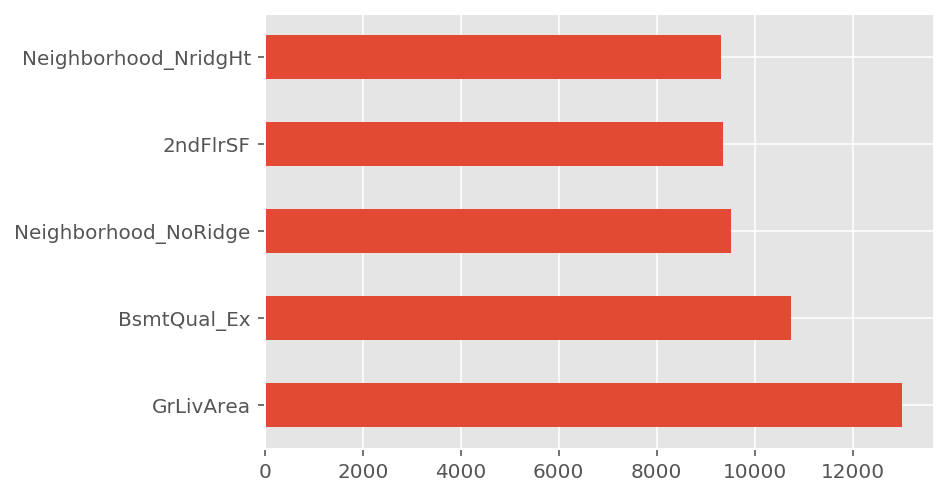

In [38]:
df_coef['coefficients'].sort_values(ascending = False).head(5).plot(kind='barh');

Greater amount of living area has the most correlation with a higher sale price, and Basement quality, neighborhood, and 2nd floor square footage also create greater sales prices.

#### Lasso CV Model

In [ ]:
model = LassoCV(alphas=np.logspace(-8, 8, 20), cv=5, max_iter = 1000000)
# fit the model
model.fit(X_train, y_train)

# evaluate on the training set
training_score = model.score(X_train, y_train)
# evaluate on the test set
test_score = model.score(X_test, y_test)

#mean cv score on training data
scores = cross_val_score(model, X_train, y_train, cv=5).mean()




/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 469402980676.0861, tolerance: 653327368.6131212
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 421931421419.17993, tolerance: 603476496.7681429
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 445127317115.20404, tolerance: 690226050.284992
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You mig

In [138]:
score_series_lasso = pd.DataFrame([training_score, test_score, scores], index = ['Training_Score', 'Test_Score', 'Mean_CV'], 
                            columns = ['LassoCV'])
score_series_lasso

LassoCV
Training_Score  0.847027
Test_Score      0.862124
Mean_CV         0.814955

In [139]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])

# calculate the absolute values of the coefficients to gauge influence (show importance of predictor variables)
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef.sort_values(by = 'coef_abs', ascending = False)[:10]

coefficients      coef_abs
GrLivArea             27704.261967  27704.261967
BsmtQual_Ex           12973.745499  12973.745499
Neighborhood_NridgHt  10401.410340  10401.410340
Neighborhood_NoRidge  10098.190258  10098.190258
GarageCars             8799.522901   8799.522901
YearRemodAdd           7375.372379   7375.372379
Neighborhood_StoneBr   7295.357408   7295.357408
YearBuilt              7000.081932   7000.081932
BldgType_1Fam          5801.708065   5801.708065
BsmtExposure_Gd        5330.994179   5330.994179

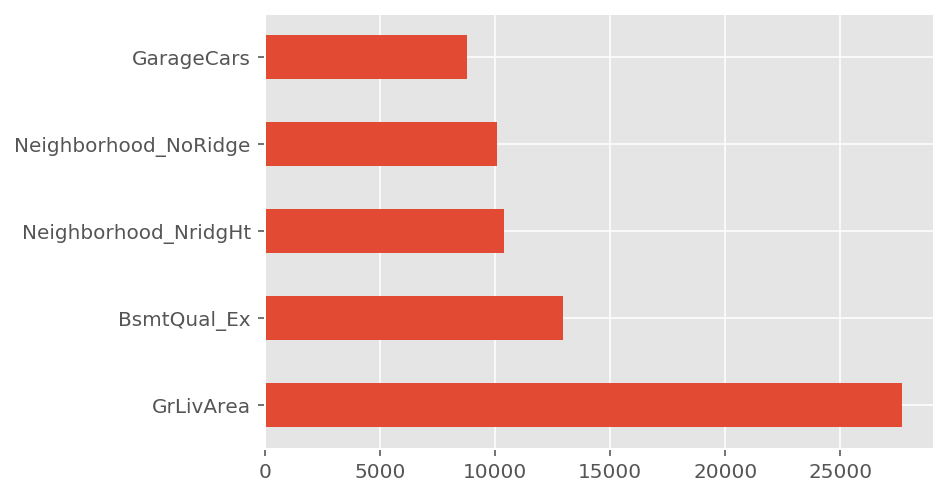

In [140]:
df_coef['coefficients'].sort_values(ascending = False).head(5).plot(kind='barh');

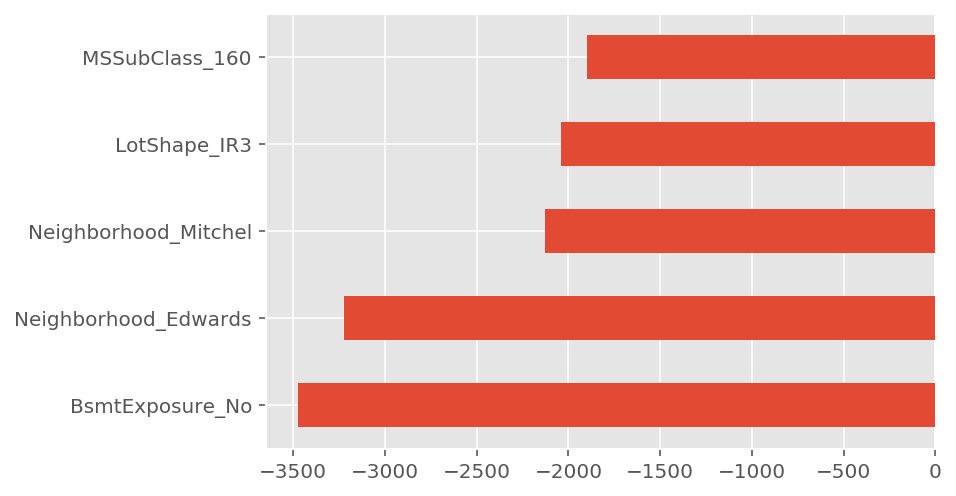

In [141]:
df_coef['coefficients'].sort_values(ascending = True).head(5).plot(kind='barh');

Similar to the Ridge model, greater amount of living area has the most correlation with a higher sale price, and Basement quality and neighborhood also create greater sales prices.


#### Elastic Net CV Model 



In [123]:
model = ElasticNetCV(alphas=np.logspace(-4, 4, 10), 
                     l1_ratio=np.array([.1, .5, .7, .9, .95, .99, 1]), max_iter = 100000,
                     cv=5)
# fit the model
model.fit(X_train, y_train)
# get the best alpha
print('Best alpha:', model.alpha_)
# get the best l1-ratio
print('Best l1-ratio:', model.l1_ratio_)

# evaluate on the training set
training_score = model.score(X_train, y_train)
# evaluate on the test set
test_score = model.score(X_test, y_test)

#mean cv score on training data
scores = cross_val_score(model, X_train, y_train, cv=5).mean()

Best alpha: 0.005994842503189409
Best l1-ratio: 0.5


In [44]:
score_series_elastic = pd.DataFrame([training_score, test_score, scores], index = ['Training_Score', 'Test_Score', 'Mean_CV'], 
                            columns = ['ElasticNetCV'])
score_series_elastic

ElasticNetCV
Training_Score      0.841846
Test_Score          0.858648
Mean_CV             0.812159

In [45]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])

# calculate the absolute values of the coefficients to gauge influence (show importance of predictor variables)
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef.sort_values(by = 'coef_abs', ascending = False)[:10]

coefficients      coef_abs
GrLivArea             26949.028493  26949.028493
BsmtQual_Ex           12986.633694  12986.633694
Neighborhood_NridgHt   9855.450715   9855.450715
Neighborhood_NoRidge   9770.889395   9770.889395
GarageCars             9126.048686   9126.048686
YearRemodAdd           7695.916143   7695.916143
YearBuilt              7536.289888   7536.289888
Neighborhood_StoneBr   6930.521612   6930.521612
BldgType_1Fam          5911.462307   5911.462307
TotalBsmtSF            5685.688340   5685.688340

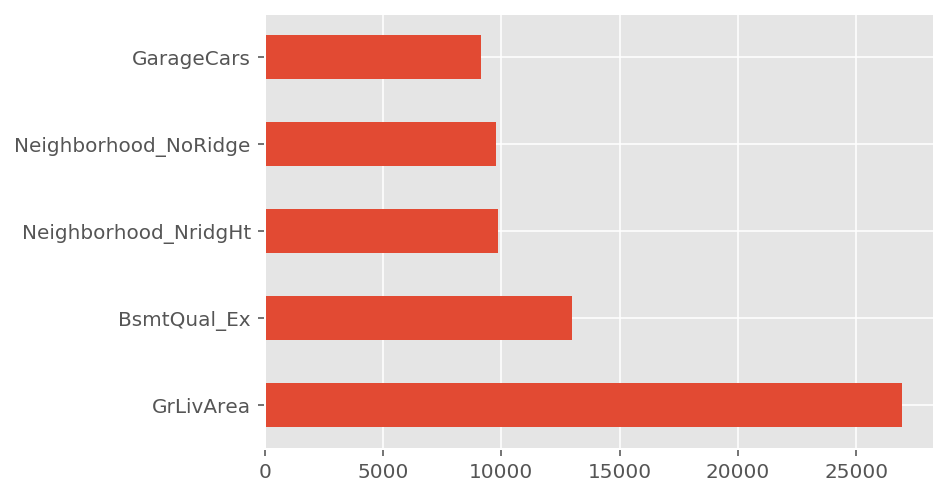

In [46]:
df_coef['coefficients'].sort_values(ascending = False).head(5).plot(kind='barh');

Similar to the previous models, Elastic Net shows that the  amount of living area has the most correlation with a higher sale price, and Basement quality, neighborhood, and garage size also create greater sales prices.



#### Compare Model Scores in DataFrame format
Lasso has the highest mean cv score, so it is currently the best model

In [47]:
# Merge three Dataframes to compare scores
mergedDf = score_series_elastic.merge(score_series_ridge, left_index=True, right_index=True)
mergedDf = mergedDf.merge(score_series_lasso, left_index = True, right_index = True)
mergedDf

ElasticNetCV   RidgeCV   LassoCV
Training_Score      0.841846  0.854696  0.847027
Test_Score          0.858648  0.863839  0.862124
Mean_CV             0.812159  0.803226  0.814955

### Modelling With the Log of y

In [48]:
#try to take log of y 
log_y_train = np.log(y_train)
log_y_test = np.log(y_test)


#### Ridge CV Model (taking the log of y)

In [49]:
# create a RidgeCV model instance
model = RidgeCV(alphas=np.logspace(-20, 20, 50), cv=5)
# fit the model
model.fit(X_train, log_y_train)

# evaluate on the training set
training_score = model.score(X_train, log_y_train)
# evaluate on the test set
test_score = model.score(X_test, log_y_test)

#mean cv score on training data
scores = cross_val_score(model, X_train, log_y_train, cv=5).mean()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.99246e-18): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.0908e-18): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.19018e-18): result may not be accurate.
  overwrite_a=True).T


In [50]:
score_series_ridge_log = pd.DataFrame([training_score, test_score, scores], index = ['Training_Score', 'Test_Score', 'Mean_CV'], 
                            columns = ['RidgeCV_log'])
score_series_ridge_log

RidgeCV_log
Training_Score     0.880928
Test_Score         0.889633
Mean_CV            0.841501

In [51]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])

# calculate the absolute values of the coefficients to gauge influence (show importance of predictor variables)
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef.sort_values(by = 'coef_abs', ascending = False)[:10]

coefficients  coef_abs
GrLivArea                 0.054763  0.054763
YearRemodAdd              0.047326  0.047326
GarageCars                0.047325  0.047325
Fireplaces                0.035080  0.035080
2ndFlrSF                  0.034691  0.034691
Neighborhood_NridgHt      0.034555  0.034555
1stFlrSF                  0.032657  0.032657
FullBath                  0.029360  0.029360
BsmtQual_Ex               0.028816  0.028816
YearBuilt                 0.028681  0.028681

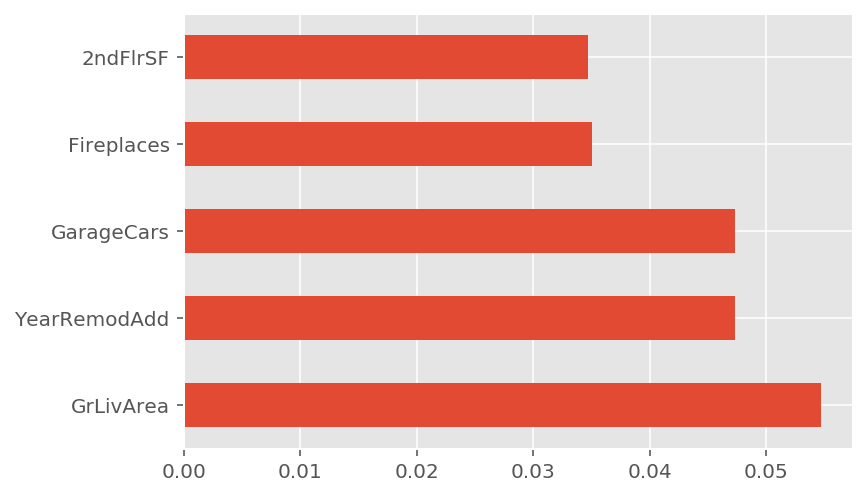

In [52]:
df_coef['coefficients'].sort_values(ascending = False).head(5).plot(kind='barh');

In this model, amount of living space, the year a remodel or addition was completed, number of cars that fit in the garage, and number of fireplaces have the greatest impact on the sale price of the home.

#### Lasso CV Model (log of y)

In [53]:
model = LassoCV(alphas=np.logspace(-8, 8, 20), cv=5)
# fit the model
model.fit(X_train, log_y_train)

# evaluate on the training set
training_score = model.score(X_train, log_y_train)
# evaluate on the test set
test_score = model.score(X_test, log_y_test)

#mean cv score on training data
scores = cross_val_score(model, X_train, log_y_train, cv=5).mean()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.258335119495554, tolerance: 0.015903091370587694
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.566097749675825, tolerance: 0.015903091370587694
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.373235197390187, tolerance: 0.015903091370587694
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.733084593354672, tolerance: 0.013463972138981123
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.739697014584274, tolerance: 0.013463972138981123
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.003163015414824, tolerance: 0.013463972138981123
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.987472225231142, tolerance: 0.011948627436351873
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.465642804171414, tolerance: 0.011948627436351873
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.594512990029072, tolerance: 0.011948627436351873
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.080260547900105, tolerance: 0.012827716247923466
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.2034880706944175, tolerance: 0.012827716247923466
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.236687603052794, tolerance: 0.012827716247923466
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge

In [54]:
score_series_lasso_log = pd.DataFrame([training_score, test_score, scores], index = ['Training_Score', 'Test_Score', 'Mean_CV'], 
                            columns = ['LassoCV_log'])
score_series_lasso_log

LassoCV_log
Training_Score     0.881633
Test_Score         0.894639
Mean_CV            0.842388

In [55]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])

# calculate the absolute values of the coefficients to gauge influence (show importance of predictor variables)
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef.sort_values(by = 'coef_abs', ascending = False)[:10]

coefficients  coef_abs
GrLivArea                 0.123100  0.123100
GarageCars                0.051435  0.051435
YearRemodAdd              0.050798  0.050798
YearBuilt                 0.042090  0.042090
Neighborhood_NridgHt      0.039975  0.039975
Fireplaces                0.036004  0.036004
BsmtQual_Ex               0.031056  0.031056
MSSubClass_160           -0.028867  0.028867
BsmtFullBath              0.027604  0.027604
FullBath                  0.027214  0.027214

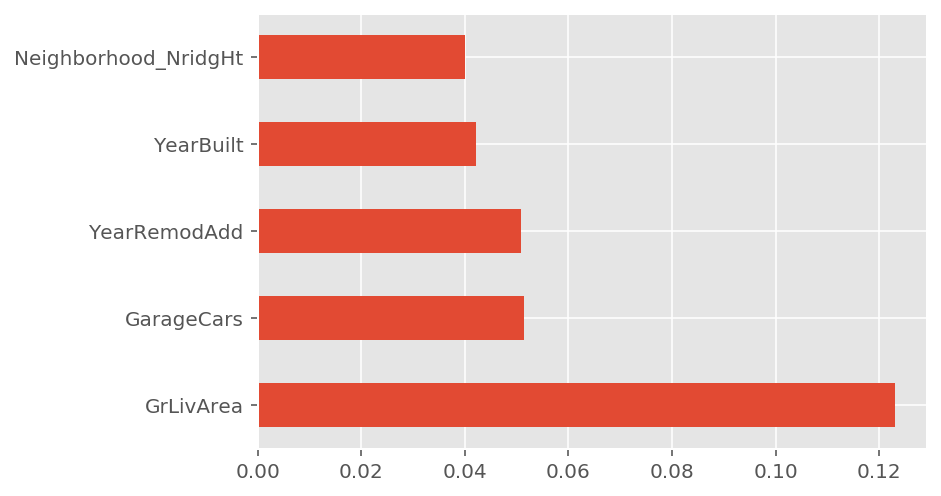

In [56]:
df_coef['coefficients'].sort_values(ascending = False).head(5).plot(kind='barh');

In this model, amount of living space, the year a remodel or addition was completed, number of cars that fit in the garage, and year the house was built have the greatest impact on the sale price of the home.


#### Elastic Net CV Model (log of y)

In [57]:
best_model = ElasticNetCV(alphas=np.logspace(-4, 4, 10), 
                     l1_ratio=np.array([.1, .5, .7, .9, .95, .99, 1]),
                     cv=5)
# fit the model
best_model.fit(X_train, log_y_train)
# get the best alpha
print('Best alpha:', best_model.alpha_)
# get the best l1-ratio
print('Best l1-ratio:', best_model.l1_ratio_)

# evaluate on the training set
training_score = best_model.score(X_train, log_y_train)
# evaluate on the test set
test_score = best_model.score(X_test, log_y_test)

#mean cv score on training data
scores = cross_val_score(best_model, X_train, log_y_train, cv=5).mean()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.252828478081699, tolerance: 0.015903091370587694
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.20600300328789, tolerance: 0.014940332747390137
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.752759247030029, tolerance: 0.015418398857549096
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. 

Best alpha: 0.046415888336127774
Best l1-ratio: 0.1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.280898634984842, tolerance: 0.012085963937666694
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.181401519907569, tolerance: 0.012123855709745926
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.80990513802621, tolerance: 0.013463972138981123
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24140229076424902, tolerance: 0.011409851728955266
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15908294401451428, tolerance: 0.011409851728955266
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.140911258476887, tolerance: 0.011409851728955266
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not conve

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01591561028345012, tolerance: 0.013215025824964824
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02188011250830968, tolerance: 0.012827716247923466
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0445887926850643, tolerance: 0.012600181736230436
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not conv

In [58]:
score_series_elastic_log = pd.DataFrame([training_score, test_score, scores], index = ['Training_Score', 'Test_Score', 'Mean_CV'], 
                            columns = ['ElasticNetCV_log'])
score_series_elastic_log

ElasticNetCV_log
Training_Score          0.873240
Test_Score              0.896111
Mean_CV                 0.844990

In [59]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(best_model.coef_, index=X_train.columns,
                       columns=['coefficients'])

# calculate the absolute values of the coefficients to gauge influence (show importance of predictor variables)
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef.sort_values(by = 'coef_abs', ascending = False)[:10]

coefficients  coef_abs
GrLivArea                 0.083409  0.083409
GarageCars                0.053928  0.053928
YearRemodAdd              0.052785  0.052785
Fireplaces                0.036554  0.036554
Neighborhood_NridgHt      0.032072  0.032072
YearBuilt                 0.030222  0.030222
BsmtQual_Ex               0.027940  0.027940
FullBath                  0.024990  0.024990
Neighborhood_Crawfor      0.023910  0.023910
BsmtFullBath              0.023289  0.023289

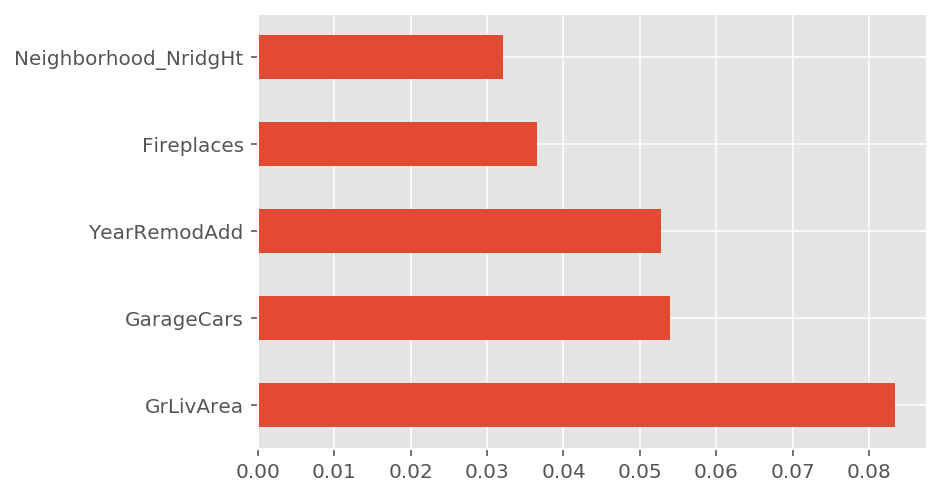

In [60]:
df_coef['coefficients'].sort_values(ascending = False).head(5).plot(kind='barh');

In this model, amount of living space, the year a remodel or addition was completed, number of cars that fit in the garage, and number of fireplaces have the greatest impact on the sale price of the home.

#### Compare model scores from all models: those with the unmodified X and Y, and with taking the log of Y

In [61]:
logDf = score_series_elastic_log.merge(score_series_ridge_log, left_index=True, right_index=True)
logDf = logDf.merge(score_series_lasso_log, left_index = True, right_index = True)

all_scores = logDf.merge(mergedDf, left_index= True, right_index = True)

all_scores

ElasticNetCV_log  RidgeCV_log  LassoCV_log  ElasticNetCV  \
Training_Score          0.873240     0.880928     0.881633      0.841846   
Test_Score              0.896111     0.889633     0.894639      0.858648   
Mean_CV                 0.844990     0.841501     0.842388      0.812159   

                 RidgeCV   LassoCV  
Training_Score  0.854696  0.847027  
Test_Score      0.863839  0.862124  
Mean_CV         0.803226  0.814955

Before taking the log of y values, the best model was Lasso, with a CV mean score of .8149

After taking the log of y, the best model was Elastic Net, with a mean CV score of .8449.

The strongest coefficients are GrLivArea, GarageCars, YearRemodAdd, Fireplaces & Neighborhood.

## Conclusion:
The best model for predicting house sale prices based on fixed features is Elastic Net CV, after taking the log of the sales prices (y values). Based on this model, the strongest predictors of price are ground floor living space, size of the garage, year a remodel or addition was completed, number of fireplaces & neighborhood. The model performs a bit better and more accurate than the models done without taking the log of sales price, but looking at the coefficients from the previous models may also be informative for the real estate company.

Before taking the log of the sales price, the best performing model was LassoCV. The coefficients can tell the company how much more or less value a house will have based on the fixed characteristics of the home. 
* Each increase by 1 sqft in Ground Floor Living Area will equate to an increase of \$27,704 in sale price
* A basement with the highest quality (Excellent) will equate to a \$12,973 greater sale price
* A home in North Ridge Heights or North Ridge will increase sale prices by about \$10,000
* Each additional car that can fit in the garage will increase the sale price by \$8,800

# 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

To gain better predictions on the house's sale price, I developed a model to predict the residuals from the previous regression model based on changeable features of the home. This model would help the real estate company evaluate the cost or benefits of renovating a home to improve its quality, condition, or etc.

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

## EDA & Feature Engineering
Looking closely at the features that can be changed

In [62]:
changeable = house[['OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
'ExterCond', 'BsmtFinType2', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtCond','HeatingQC','KitchenQual','GarageFinish', 'GarageQual', 'YrSold']]
changeable.head()

OverallQual  OverallCond RoofStyle Exterior1st Exterior2nd MasVnrType  \
0            7            5     Gable     VinylSd     VinylSd    BrkFace   
1            6            8     Gable     MetalSd     MetalSd       None   
2            7            5     Gable     VinylSd     VinylSd    BrkFace   
3            7            5     Gable     Wd Sdng     Wd Shng       None   
4            8            5     Gable     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond BsmtFinType2 BsmtFinType1  BsmtFinSF1  \
0       196.0        Gd        TA          Unf          GLQ         706   
1         0.0        TA        TA          Unf          ALQ         978   
2       162.0        Gd        TA          Unf          GLQ         486   
3         0.0        TA        TA          Unf          ALQ         216   
4       350.0        Gd        TA          Unf          GLQ         655   

   BsmtFinSF2  BsmtUnfSF BsmtCond HeatingQC KitchenQual GarageFinish  \
0           0        150       TA        Ex          Gd          RFn   
1           0        284       TA        Ex          TA          RFn   
2           0        434       TA        Ex          Gd          RFn   
3           0        540       Gd        Gd          Gd          Unf   
4           0        490       TA        Ex          Gd          RFn   

  GarageQual  YrSold  
0         TA    2008  
1         TA    2007  
2         TA    2008  
3         TA    2006  
4         TA    2008

In [63]:
changeable.isnull().sum()

OverallQual      0
OverallCond      0
RoofStyle        0
Exterior1st      0
Exterior2nd      0
MasVnrType       8
MasVnrArea       8
ExterQual        0
ExterCond        0
BsmtFinType2    38
BsmtFinType1    37
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
BsmtCond        37
HeatingQC        0
KitchenQual      0
GarageFinish    79
GarageQual      79
YrSold           0
dtype: int64

In [64]:
#na was automatically put as NaN
#change back to 'NA'
changeable.MasVnrType.fillna('NA', inplace=True)
changeable.MasVnrArea.fillna('NA', inplace=True)
changeable.BsmtFinType2.fillna('NA', inplace=True)
changeable.BsmtFinType1.fillna('NA', inplace=True)
changeable.BsmtCond.fillna('NA', inplace=True)
changeable.GarageFinish.fillna('NA', inplace=True)
changeable.GarageQual.fillna('NA', inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [65]:
changeable.isnull().sum()

OverallQual     0
OverallCond     0
RoofStyle       0
Exterior1st     0
Exterior2nd     0
MasVnrType      0
MasVnrArea      0
ExterQual       0
ExterCond       0
BsmtFinType2    0
BsmtFinType1    0
BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
BsmtCond        0
HeatingQC       0
KitchenQual     0
GarageFinish    0
GarageQual      0
YrSold          0
dtype: int64

In [66]:
changeable[['Exterior1st', 'Exterior2nd']]
changeable[changeable.Exterior1st == changeable.Exterior2nd]
#nearly all of the data is the same between exterior 1st & 2nd so 2nd can be deleted

changeable.drop('Exterior2nd', axis = 1, inplace = True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [67]:
changeable.shape

(1450, 19)

In [68]:
changeable[changeable.MasVnrType == 'None']
#over half of the MasVnrType is None, so it can be deleted

changeable.drop('MasVnrType', axis = 1, inplace = True)

In [69]:
changeable[changeable.BsmtFinSF2 == 0]
#almost all values in BsmtFinSF2 are 0 so they can be deleted
changeable.drop('BsmtFinSF2', axis = 1, inplace = True)

In [70]:
changeable[changeable.BsmtFinType2 == 'Unf']
#almost all values for BsmtFinType2 are Unf so it can be dropped
changeable.drop('BsmtFinType2', axis = 1, inplace = True)

In [71]:
changeable.MasVnrArea.value_counts()
#over 800 have 0 and the rest have about 1 in each value
changeable.drop('MasVnrArea', axis = 1, inplace = True)

In [72]:
changeable.head()

OverallQual  OverallCond RoofStyle Exterior1st ExterQual ExterCond  \
0            7            5     Gable     VinylSd        Gd        TA   
1            6            8     Gable     MetalSd        TA        TA   
2            7            5     Gable     VinylSd        Gd        TA   
3            7            5     Gable     Wd Sdng        TA        TA   
4            8            5     Gable     VinylSd        Gd        TA   

  BsmtFinType1  BsmtFinSF1  BsmtUnfSF BsmtCond HeatingQC KitchenQual  \
0          GLQ         706        150       TA        Ex          Gd   
1          ALQ         978        284       TA        Ex          TA   
2          GLQ         486        434       TA        Ex          Gd   
3          ALQ         216        540       Gd        Gd          Gd   
4          GLQ         655        490       TA        Ex          Gd   

  GarageFinish GarageQual  YrSold  
0          RFn         TA    2008  
1          RFn         TA    2007  
2          RFn         TA    2008  
3          Unf         TA    2006  
4          RFn         TA    2008

In [73]:
changeable.columns

Index(['OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st', 'ExterQual',
       'ExterCond', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtUnfSF', 'BsmtCond',
       'HeatingQC', 'KitchenQual', 'GarageFinish', 'GarageQual', 'YrSold'],
      dtype='object')

In [74]:
#change columns to categorical
for col in ['ExterQual', 'ExterCond', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'GarageQual', 'BsmtFinType1', 'GarageFinish']:
    changeable[col] = changeable[col].astype('category')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [75]:
changeable.dtypes

OverallQual        int64
OverallCond        int64
RoofStyle         object
Exterior1st       object
ExterQual       category
ExterCond       category
BsmtFinType1    category
BsmtFinSF1         int64
BsmtUnfSF          int64
BsmtCond        category
HeatingQC       category
KitchenQual     category
GarageFinish    category
GarageQual      category
YrSold             int64
dtype: object

In [76]:
changeable

OverallQual  OverallCond RoofStyle Exterior1st ExterQual ExterCond  \
0               7            5     Gable     VinylSd        Gd        TA   
1               6            8     Gable     MetalSd        TA        TA   
2               7            5     Gable     VinylSd        Gd        TA   
3               7            5     Gable     Wd Sdng        TA        TA   
4               8            5     Gable     VinylSd        Gd        TA   
...           ...          ...       ...         ...       ...       ...   
1455            6            5     Gable     VinylSd        TA        TA   
1456            6            6     Gable     Plywood        TA        TA   
1457            7            9     Gable     CemntBd        Ex        Gd   
1458            5            6       Hip     MetalSd        TA        TA   
1459            5            6     Gable     HdBoard        Gd        TA   

     BsmtFinType1  BsmtFinSF1  BsmtUnfSF BsmtCond HeatingQC KitchenQual  \
0             GLQ         706        150       TA        Ex          Gd   
1             ALQ         978        284       TA        Ex          TA   
2             GLQ         486        434       TA        Ex          Gd   
3             ALQ         216        540       Gd        Gd          Gd   
4             GLQ         655        490       TA        Ex          Gd   
...           ...         ...        ...      ...       ...         ...   
1455          Unf           0        953       TA        Ex          TA   
1456          ALQ         790        589       TA        TA          TA   
1457          GLQ         275        877       Gd        Ex          Gd   
1458          GLQ          49          0       TA        Gd          Gd   
1459          BLQ         830        136       TA        Gd          TA   

     GarageFinish GarageQual  YrSold  
0             RFn         TA    2008  
1             RFn         TA    2007  
2             RFn         TA    2008  
3             Unf         TA    2006  
4             RFn         TA    2008  
...           ...        ...     ...  
1455          RFn         TA    2007  
1456          Unf         TA    2010  
1457          RFn         TA    2010  
1458          Unf         TA    2010  
1459          Fin         TA    2008  

[1450 rows x 15 columns]

In [77]:
#dummify columns: RoofStyle, Exterior1st

changeable = pd.get_dummies(changeable, columns = ['RoofStyle', 'Exterior1st', 'ExterQual', 'ExterCond', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'GarageQual', 'BsmtFinType1', 'GarageFinish'], drop_first = True)

In [78]:
changeable.head()


OverallQual  OverallCond  BsmtFinSF1  BsmtUnfSF  YrSold  RoofStyle_Gable  \
0            7            5         706        150    2008                1   
1            6            8         978        284    2007                1   
2            7            5         486        434    2008                1   
3            7            5         216        540    2006                1   
4            8            5         655        490    2008                1   

   RoofStyle_Gambrel  RoofStyle_Hip  RoofStyle_Mansard  RoofStyle_Shed  ...  \
0                  0              0                  0               0  ...   
1                  0              0                  0               0  ...   
2                  0              0                  0               0  ...   
3                  0              0                  0               0  ...   
4                  0              0                  0               0  ...   

   GarageQual_TA  BsmtFinType1_BLQ  BsmtFinType1_GLQ  BsmtFinType1_LwQ  \
0              1                 0                 1                 0   
1              1                 0                 0                 0   
2              1                 0                 1                 0   
3              1                 0                 0                 0   
4              1                 0                 1                 0   

   BsmtFinType1_NA  BsmtFinType1_Rec  BsmtFinType1_Unf  GarageFinish_NA  \
0                0                 0                 0                0   
1                0                 0                 0                0   
2                0                 0                 0                0   
3                0                 0                 0                0   
4                0                 0                 0                0   

   GarageFinish_RFn  GarageFinish_Unf  
0                 1                 0  
1                 1                 0  
2                 1                 0  
3                 0                 1  
4                 1                 0  

[5 rows x 56 columns]

## Modelling
### This model will take the changeable features from the homes to predict the residuals from the previous model. 
This would help the company gain a better understanding of the home's sale price based on both fixed and changeable features of the home. 

In [79]:
#define residuals from previous model
#have to use log_y_train/test since the model used the log of y

new_y_train = best_model.predict(X_train)
train_res = log_y_train - new_y_train

new_y_test = best_model.predict(X_test)
test_res = log_y_test - new_y_test

In [80]:
#define X test and train, split between before and after 2010
X_train_new = changeable[changeable.YrSold < 2010]
X_test_new = changeable[changeable.YrSold >= 2010]

In [81]:
#standardize
scaler = StandardScaler()
X_train_new = pd.DataFrame(scaler.fit_transform(X_train_new), columns=X_train_new.columns)
X_test_new = pd.DataFrame(scaler.transform(X_test_new), columns=X_test_new.columns)

### Linear Regression Model

In [82]:
model = LinearRegression()
model.fit(X_train_new, train_res)

# get cross validated scores
scores = cross_val_score(model, X_train_new, train_res, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())


print("Training Score:", model.score(X_train_new, train_res))
print("Test Score:", model.score(X_test_new, test_res))

# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(model.coef_, index=X_train_new.columns,
                       columns=['coefficients'])

# calculate the absolute values of the coefficients to gauge influence (show importance of predictor variables)
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef.sort_values(by = 'coef_abs', ascending = False)[:5]

Cross-validated training scores: [ 9.84681344e-02  1.42355610e-01  1.07476173e-01 -3.57759987e+20
 -7.40157750e-04]
Mean cross-validated training score: -7.1551997365514035e+19
Training Score: 0.24695681250152068
Test Score: -7.263722837011078e+20


coefficients      coef_abs
GarageQual_NA       -5.919789e+11  5.919789e+11
GarageFinish_NA      5.919789e+11  5.919789e+11
BsmtFinType1_NA      5.376167e+10  5.376167e+10
BsmtCond_NA         -5.376167e+10  5.376167e+10
Exterior1st_AsphShn  4.310273e+10  4.310273e+10

This model, while the scores are not high enough for the feature importance to be extremely useful, shows that the quality and condition of basements and garages are important factors for predicting the residuals from the previous model.

### RidgeCV Model 

In [83]:
model = RidgeCV(alphas=np.logspace(-10, 10, 20), cv=5)
# fit the model
model.fit(X_train_new, train_res)
# get the best alpha
print('Best alpha:', model.alpha_)
# evaluate on the training set
print('Training score:', model.score(X_train_new, train_res))
# evaluate on the test set
print("Test Score:", model.score(X_test_new, test_res))

scores = cross_val_score(model, X_train_new, train_res, cv=5)
print("Mean cross-validated training score:", scores.mean())

# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(model.coef_, index=X_train_new.columns,
                       columns=['coefficients'])

# calculate the absolute values of the coefficients to gauge influence (show importance of predictor variables)
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef.sort_values(by = 'coef_abs', ascending = False)[:5]

Best alpha: 428.13323987193957
Training score: 0.21299346937129937
Test Score: 0.08291031395167103
Mean cross-validated training score: 0.1286598719524564


coefficients  coef_abs
OverallCond              0.027987  0.027987
OverallQual              0.025166  0.025166
Exterior1st_BrkFace      0.014966  0.014966
BsmtFinType1_Unf        -0.013148  0.013148
BsmtFinSF1              -0.008990  0.008990

This model performs better than the linear regression model, and this ridge model shows that overall quality and condition are the strongest predictors for predicting residuals from the previous regression model.

### Lasso CV Model

In [125]:
model = LassoCV(alphas=np.logspace(-8, 8, 20), cv=5)
# fit the model
model.fit(X_train_new, train_res)
# get the best alpha
print('Best alpha:', model.alpha_)
# evaluate on the training set
print('Training score:', model.score(X_train_new, train_res))
# evaluate on the test set
print("Test Score:", model.score(X_test_new, test_res))

scores = cross_val_score(model, X_train_new, train_res, cv=5)
print("Mean cross-validated training score:", scores.mean())

# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(model.coef_, index=X_train_new.columns,
                       columns=['coefficients'])

# calculate the absolute values of the coefficients to gauge influence (show importance of predictor variables)
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef.sort_values(by = 'coef_abs', ascending = False)[:5]

Best alpha: 0.007847599703514606
Training score: 0.17730353996067516
Test Score: 0.11341020523507261
Mean cross-validated training score: 0.1666811348765594


coefficients  coef_abs
OverallCond              0.031400  0.031400
OverallQual              0.030740  0.030740
Exterior1st_BrkFace      0.012051  0.012051
BsmtFinType1_Unf        -0.009750  0.009750
Exterior1st_BrkComm     -0.002815  0.002815

Similarly to the ridge model, this model shows that overall condition and quality are the strongest predictors. The exterior finish of the house and status of the basement are both important predictors as well. 

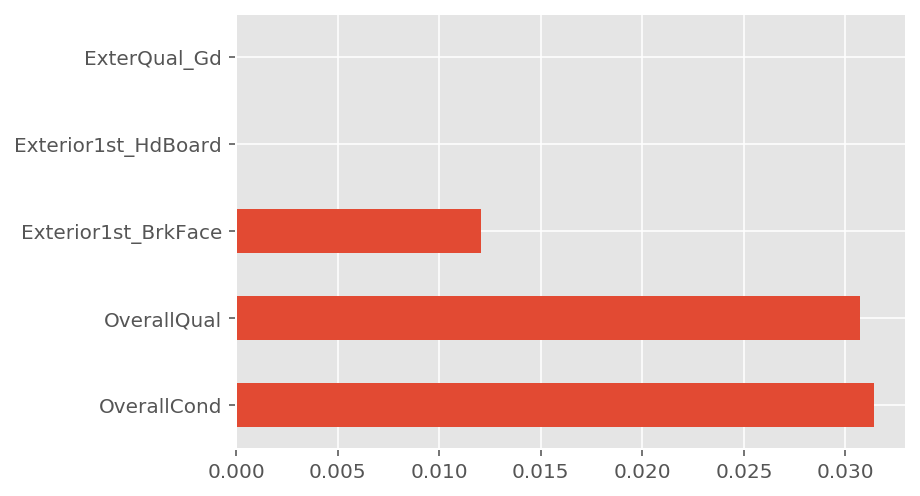

In [127]:
df_coef['coefficients'].sort_values(ascending = False).head(5).plot(kind='barh');

### Elastic Net CV Model

In [85]:
model = ElasticNetCV(alphas=np.logspace(-4, 4, 10), 
                     l1_ratio=np.array([.1, .5, .7, .9, .95, .99, 1]),
                     cv=5)
# fit the model
model.fit(X_train_new, train_res)
# get the best alpha
print('Best alpha:', model.alpha_)
# get the best l1-ratio
print('Best l1-ratio:', model.l1_ratio_)
# evaluate on the training set
print('Training score:', model.score(X_train_new, train_res))
# evaluate on the test set
print("Test Score:", model.score(X_test_new, test_res))

scores = cross_val_score(model, X_train_new, train_res, cv=5)
print("Mean cross-validated training score:", scores.mean())

# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(model.coef_, index=X_train_new.columns,
                       columns=['coefficients'])

# calculate the absolute values of the coefficients to gauge influence (show importance of predictor variables)
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef.sort_values(by = 'coef_abs', ascending = False)[:5]

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02560647832487284, tolerance: 0.002151846649221781
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028174653056007415, tolerance: 0.0018507377297243069
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04759689400712297, tolerance: 0.0018507377297243069
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not 

Best alpha: 0.005994842503189409
Best l1-ratio: 1.0
Training score: 0.18521688022690874
Test Score: 0.1094479639707888


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012034005976834905, tolerance: 0.001634500283781409
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024558989070213144, tolerance: 0.0018656687181616016
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015214109762398564, tolerance: 0.0018685388602900789
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did no

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012949902624232124, tolerance: 0.001836653871209318
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03736106913273396, tolerance: 0.001836653871209318
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018103006836074798, tolerance: 0.0017229314571932997
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not 

Mean cross-validated training score: 0.1619833672049939


coefficients  coef_abs
OverallCond              0.033226  0.033226
OverallQual              0.032536  0.032536
Exterior1st_BrkFace      0.013948  0.013948
BsmtFinType1_Unf        -0.011429  0.011429
Exterior1st_BrkComm     -0.004207  0.004207

As the previous two models showed, the most important predictors are overall quality and condition of the house, exterior finish and status of the basement. Since all of the models agree on these features it can be assumed that these are important factors in predicting the residuals from the original regression model.

## Conclusion:
Lasso performed the best of this second regression model, but all four models had extremely low scores. The most influential coefficients were Overall Condition and Overall Quality, but all of the coefficients were quite low, suggesting that they would not have a large impact on the sale price of the home. I would not trust this model to predict price based on changeable features of a house. Even the greatest coefficient, .03, would suggest that that feature would increase the sales price by just 3%. It would be best for the real estate company to judge sale price based on fixed features of the home, as shown in the model for question 1. The model in question 1 produced much more accurate predictions, and since the coefficients were much larger, those features had much stronger value for the home.

# 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
If it is possible to predict which characteristics produce an abnormal sale, the real estate agency could know ahead of time which houses may have an usual sale (short sale, foreclosure, etc...) and may allow them to buy the house for a lower price. 

---

**Goals:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature by using a classification analysis.
- Justify your results.

## EDA & Feature Engineering

In [86]:
house.SaleCondition

0        Normal
1        Normal
2        Normal
3       Abnorml
4        Normal
         ...   
1455     Normal
1456     Normal
1457     Normal
1458     Normal
1459     Normal
Name: SaleCondition, Length: 1450, dtype: object

In [87]:
f = fixed_dummy.columns
c = changeable.columns
for x in f:
    if x in c:
        print(x)

YrSold


In [88]:
#join two cleaned data sets (fixed and changeable features)
new_fixed = fixed_dummy.drop('YrSold',axis = 1)

full_df = pd.concat([new_fixed, changeable], axis = 1)

full_df.shape

(1450, 178)

In [89]:
#add in columns related to sales that were previously dropped
full_df['SalePrice'] = house.SalePrice
full_df['SaleType'] = house.SaleType
full_df['SaleCondition'] = house.SaleCondition

In [90]:
full_df.head()

LotFrontage  LotArea  YearBuilt  YearRemodAdd  TotalBsmtSF  1stFlrSF  \
0         65.0     8450       2003          2003          856       856   
1         80.0     9600       1976          1976         1262      1262   
2         68.0    11250       2001          2002          920       920   
3         60.0     9550       1915          1970          756       961   
4         84.0    14260       2000          2000         1145      1145   

   2ndFlrSF  GrLivArea  BsmtFullBath  FullBath  ...  BsmtFinType1_GLQ  \
0       854       1710             1         2  ...                 1   
1         0       1262             0         2  ...                 0   
2       866       1786             1         2  ...                 1   
3       756       1717             1         1  ...                 0   
4      1053       2198             1         2  ...                 1   

   BsmtFinType1_LwQ  BsmtFinType1_NA  BsmtFinType1_Rec  BsmtFinType1_Unf  \
0                 0                0                 0                 0   
1                 0                0                 0                 0   
2                 0                0                 0                 0   
3                 0                0                 0                 0   
4                 0                0                 0                 0   

   GarageFinish_NA  GarageFinish_RFn  GarageFinish_Unf  SaleType  \
0                0                 1                 0        WD   
1                0                 1                 0        WD   
2                0                 1                 0        WD   
3                0                 0                 1        WD   
4                0                 1                 0        WD   

   SaleCondition  
0         Normal  
1         Normal  
2         Normal  
3        Abnorml  
4         Normal  

[5 rows x 180 columns]

In [91]:
full_df.SaleType.value_counts()

WD       1261
New       122
COD        41
ConLD       7
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

In [92]:
full_df.SaleCondition.value_counts()

Normal     1194
Partial     125
Abnorml      96
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [93]:
full_df.SaleCondition

0        Normal
1        Normal
2        Normal
3       Abnorml
4        Normal
         ...   
1455     Normal
1456     Normal
1457     Normal
1458     Normal
1459     Normal
Name: SaleCondition, Length: 1450, dtype: object

In [94]:
#dummify new column

full_df = pd.get_dummies(full_df, columns = ['SaleType'], drop_first = True)

In [95]:
full_df.SaleCondition.value_counts(normalize =True)

Normal     0.823448
Partial    0.086207
Abnorml    0.066207
Family     0.013793
Alloca     0.007586
AdjLand    0.002759
Name: SaleCondition, dtype: float64

In [96]:
#binarize the y values so it is 1 if it is abnormal and 0 for everything else
bin_y = [1 if value=='Abnorml' else 0 for value in full_df.SaleCondition]
full_df['y'] = bin_y
full_df.drop('SaleCondition', axis = 1, inplace = True)

In [97]:
full_df.y.value_counts(normalize = True)
#with all of the data the baseline for predicting it is not an abnormal sale is 93%
#the data analyzed will need to be altered so that predicting abnormal sales can be more accurate

0    0.933793
1    0.066207
Name: y, dtype: float64

## Modelling

In [121]:
training_data = full_df[full_df.YrSold < 2010]
test_data = full_df[full_df.YrSold >= 2010]
X_train = training_data
y_train = training_data.pop('y')
X_test = test_data
y_test = test_data.pop('y')

In [101]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=training_data.columns)
X_test = pd.DataFrame(X_test, columns=training_data.columns)

### Use RandomUnderSampler to undersample majority class

In [102]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import StratifiedKFold

#set sample sizes between abnormal and rest of categories even to prevent huge imbalance
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=1)
X_train_res, y_train_res = undersample.fit_sample(X_train, y_train)

#sizes of classes before and after undersampling
print('Distribution of class labels before undersampling: {}'.format(Counter(y_train)))
print('Distribution of class labels after undersampling: {}'.format(Counter(y_train_res)))

Distribution of class labels before undersampling: Counter({0: 1191, 1: 87})
Distribution of class labels after undersampling: Counter({0: 87, 1: 87})


### Logistic Regression

In [107]:
lr = LogisticRegression(solver='lbfgs', max_iter=100,class_weight = 'balanced')

gs_params = {'penalty': ['l1', 'l2'],
             'solver': ['liblinear'],
             'C': np.logspace(-3, 0, 50)}

# create your gridsearch object to find best options
lr_gridsearch = GridSearchCV(lr,
                             gs_params,
                             n_jobs=-1, 
                             cv=5, 
                             verbose=1)
lr_gridsearch.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 115 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 493 out of 500 | elapsed:    5.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([0.001     , 0.001151...
       0.03393222, 0.0390694 , 0.04498433, 0.05179475, 0.05963623,
       0.06866488, 0.07906043, 0.09102982, 0.10481131, 0.12067926,
       0.13894955, 0.15998587, 0.184207  , 0.21209509, 0.24420531,
       0.28117687, 0.32374575, 0.37275937, 0.42919343, 0.49417134,
       0.5689866 , 

In [108]:
print(lr_gridsearch.best_score_)
print(lr_gridsearch.best_params_)

0.6381512605042017
{'C': 0.05963623316594643, 'penalty': 'l2', 'solver': 'liblinear'}


In [109]:
best_lr = lr_gridsearch.best_estimator_
#this saves the best model created from best parameters as a new variable

In [110]:
# create a dataframe to look at the coefficients
coef_df = pd.DataFrame({'feature': X_train_res.columns,
                        'coef': best_lr.coef_[0],
                        'abs_coef': np.abs(best_lr.coef_[0])})


In [111]:
# sort by absolute value of coefficient (magnitude)
coef_df.sort_values('abs_coef', ascending=False, inplace=True)
coef_df.head(10)

feature      coef  abs_coef
185           SaleType_WD -0.348155  0.348155
63   Neighborhood_NoRidge  0.329177  0.329177
3            YearRemodAdd -0.297781  0.297781
183          SaleType_New -0.294645  0.294645
28          MSSubClass_80  0.246399  0.246399
23          MSSubClass_45 -0.215487  0.215487
115              MoSold_6 -0.213600  0.213600
55   Neighborhood_Edwards -0.209266  0.209266
136   Exterior1st_CemntBd -0.199048  0.199048
125             BsmtUnfSF -0.197796  0.197796

In [116]:
coef_df.set_index('feature', inplace = True)

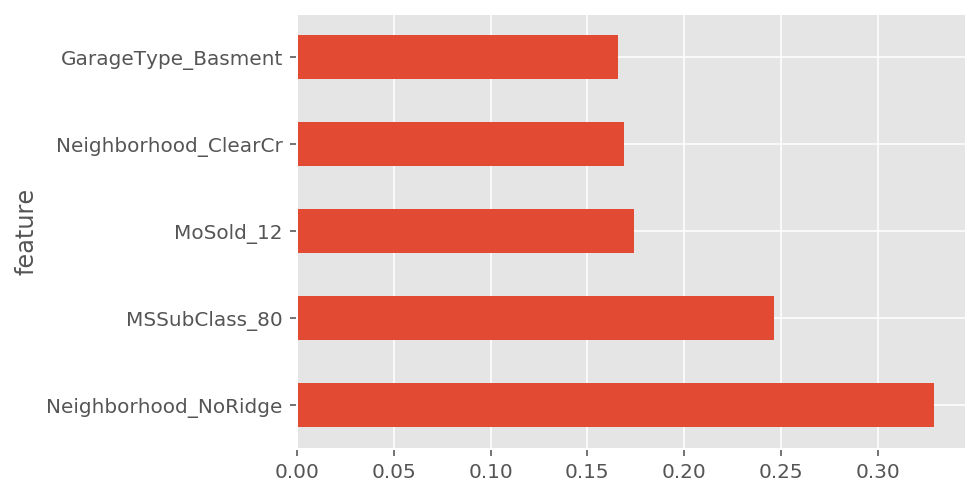

In [117]:
coef_df['coef'].sort_values(ascending = False).head(5).plot(kind='barh');

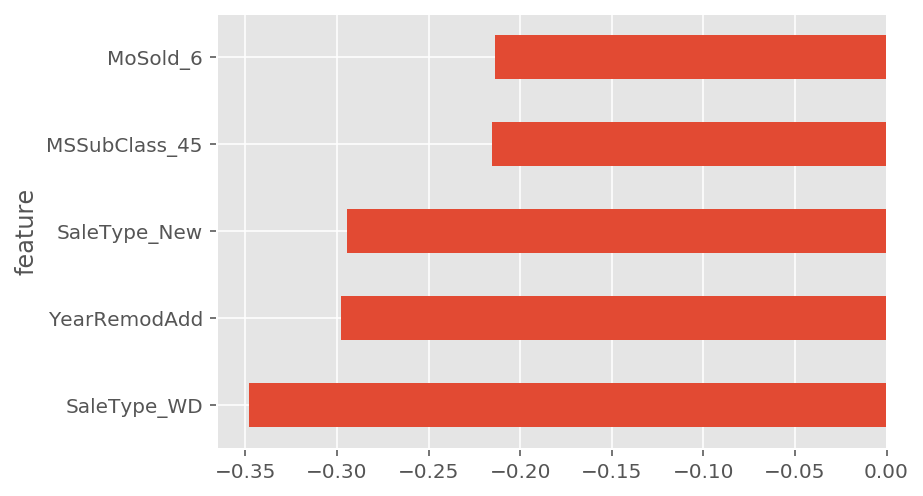

In [118]:
coef_df['coef'].sort_values(ascending = True).head(5).plot(kind='barh');

## Conclusion:
The model score is roughly .64 so it is not perfect at predicting, but is potentially more accurate than using the original data which would guess a normal sale since the majority of the data was in that category. By undersampling the data, the model is now able to guess both categories more effectively. 

It is more likely for a home to have an abnormal sale if it is not a Warranty Deed - Conventional Sale type, if it is in Northridge neighborhood, if it has not had a remodel done recently, and if it is not a new construction home being sold. This means that an abnormal sale is most likely to be influenced by the type of sale of the home and the location it is in. Since it would not be possible to know what type of sale a house would have before predicting if the sale is abnormal or not, the most accurate predictors would be the home's location, when it was remodeled, and when when the sale is taking place. 

This model is perhaps not the most reliable, and further research should be done by the real estate company before spending lots of money on a property. However this does provide a good framework on what the company can look out for.
